In [104]:
import pandas as pd
import numpy as np

import wandb
import matplotlib.pyplot as plt
import dotenv
api = wandb.Api()
dotenv.load_dotenv()

runs = api.runs(dotenv.get_key('.env', 'WANDB_URL'), {"group": {"$regex": "runtime.*"}})

In [105]:
summary_list, config_list, name_list = [], [], []

memory = []
tasks = []
models = []
runtime = []
for run in runs:
    summary_list.append(run.summary._json_dict)
    memory.append(pd.Series(run.history(stream='events')['system.gpu.0.memoryAllocatedBytes']).interpolate(method="linear", limit_direction="both").tolist())

    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})
    name_list.append(run.name)
    tasks.append(run.config['task_name'])
    models.append(run.config['model'])
    runtime.append(run.summary['_runtime'])

df = pd.DataFrame({
    'model': models,
    'task_name': tasks,
    "memory": memory,
    "runtime": runtime,
})

df.head(10)

,model,task_name,memory,runtime
0,Graphormer,driver-top3,"[43810750464.0, 34506735616.0, 25202720768.0, ...",355.531186
1,Graphormer,driver-top3,"[29118103552.0, 29118103552.0, 29118103552.0, ...",352.858604
2,Graphormer,driver-top3,"[20159070208.0, 23548067840.0, 26937065472.0, ...",350.855769
3,Graphormer,driver-top3,"[38129565696.0, 38130264746.666664, 3813096379...",357.758009
4,FraudGT,ad-ctr,"[1699938304.0, 1701336405.3333333, 1702734506....",163.141244
5,Graphormer,driver-top3,"[16900096000.0, 16900096000.0, 16900096000.0, ...",354.698609
6,FraudGT,ad-ctr,"[1702035456.0, 1703084032.0, 1704132608.0, 170...",166.761686
7,FraudGT,ad-ctr,"[1699938304.0, 1700986880.0, 1702035456.0, 170...",163.854053
8,FraudGT,ad-ctr,"[1699938304.0, 1701336405.3333333, 1702734506....",162.095901
9,FraudGT,ad-ctr,"[1699938304.0, 1701336405.3333333, 1702734506....",162.580496


In [106]:
def mean(list_of_arrays):
    max_len = max(np.array(arr).shape[0] for arr in list_of_arrays)
    # pad each array to that length, filling with NaN
    padded = [
        np.pad(arr,
               pad_width=(0, max_len - np.array(arr).shape[0]),
               constant_values=np.nan)
        for arr in list_of_arrays
    ]
    # now this will work
    stacked = np.vstack(padded) * 1e-9
    return np.mean(np.nanmean(stacked, axis=0)), np.mean(np.nanstd(stacked, axis=0))

avg_memory = df.groupby(['model', 'task_name'])['memory'].apply(lambda lists: mean(lists)).apply(pd.Series).rename(columns={0: 'mean', 1: 'std'})
avg_memory = avg_memory.reset_index()
avg_memory.head()

,model,task_name,mean,std
0,FraudGT,ad-ctr,1.703780,0.000122
1,FraudGT,driver-top3,1.166501,0.005630
2,Graphormer,ad-ctr,36.100809,7.104464
3,Graphormer,driver-top3,28.354019,9.845876


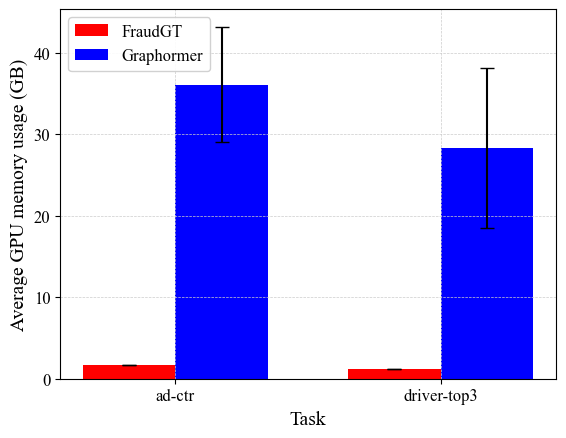

In [107]:
plt.rcParams.update({
    "font.family":       "serif",
    "font.serif":        ["Times New Roman", "Palatino", "STIX"],
    "mathtext.fontset":  "stix",         # use STIX fonts for math
    "text.usetex":       False,          # or True if you have LaTeX installed

    # 2) Axis titles and tick labels
    "axes.labelsize":    14,
    "axes.titlesize":    16,
    "xtick.labelsize":   12,
    "ytick.labelsize":   12,
    "xtick.direction":   "out",
    "ytick.direction":   "out",

    # 3) Grid style
    "axes.grid":         True,
    "grid.color":        "0.8",          # light grey
    "grid.linestyle":    "--",
    "grid.linewidth":    0.5,

    # 4) Legend styling
    "legend.frameon":    True,
    "legend.framealpha": 0.9,
    "legend.edgecolor":  "0.8",
    "legend.fontsize":   12,
})


fraud_means = avg_memory.iloc[0:2]['mean']
fraud_std = avg_memory.iloc[0:2]['std']
graphormer_means = avg_memory.iloc[2:4]['mean']
graphormer_std = avg_memory.iloc[2:4]['std']

tasks = ['ad-ctr', 'driver-top3']
# Plot
x = np.arange(len(tasks))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, fraud_means, width, label='FraudGT', color='red', yerr=fraud_std)
ax.bar(x + width/2, graphormer_means, width, label='Graphormer', color='blue', yerr=graphormer_std)


# Labels and aesthetics
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.set_xlabel('Task')
ax.set_ylabel('Average GPU memory usage (GB)')
ax.legend()

plt.savefig('memory.pdf')
plt.show()

In [108]:
avg_runtime  =df.groupby(['model', 'task_name'])['runtime'].mean().apply(pd.Series).reset_index().rename(columns={0: 'mean'})
std_runtime = df.groupby(['model', 'task_name'])['runtime'].std().apply(pd.Series).reset_index().rename(columns={0: 'std'})

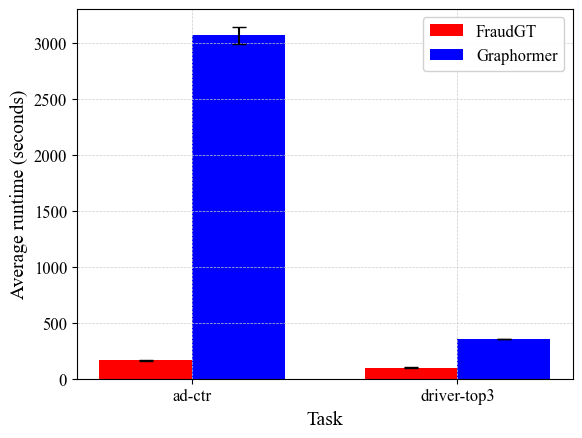

In [109]:
fraud_means = avg_runtime.iloc[0:2]['mean']
fraud_std = std_runtime.iloc[0:2]['std']
graphormer_means = avg_runtime.iloc[2:4]['mean']
graphormer_std = std_runtime.iloc[2:4]['std']

tasks = ['ad-ctr', 'driver-top3']
# Plot
x = np.arange(len(tasks))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, fraud_means, width, label='FraudGT', color='red', yerr=fraud_std)
ax.bar(x + width/2, graphormer_means, width, label='Graphormer', color='blue', yerr=graphormer_std)


# Labels and aesthetics
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.set_xlabel('Task')
ax.set_ylabel('Average runtime (seconds)')
ax.legend()

plt.savefig('runtime.pdf')
plt.show()